# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from os import listdir
from os.path import isfile, join

In [3]:
import re

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import matplotlib.pyplot as plt

# Load Data

In [6]:
listDataPretrainedModel = []

In [7]:
def readDataSet(path):
    try:
        df = pd.read_excel(path)
    except Exception:
        df = pd.read_csv(path)
    return df

def addDataPretrainedModel(path):
    listDataPretrainedModel.append(readDataSet(path))

In [8]:
onlyfiles = [f for f in listdir("../Dataset") if isfile(join("../Dataset", f))]

In [10]:
for file in onlyfiles:
    pathFile = join('../Dataset/', file)
    addDataPretrainedModel(path=pathFile)

# Preprocessing

## Based

In [28]:
def clean_column_names(df):
    def clean_name(name):
        name = name.lower()
        name = re.sub(r'[^\w]', '', name)
        name = name.replace(' ', '')
        name = name.replace('_', '')
        return name
    
    df.columns = [clean_name(col) for col in df.columns]
    df = df.loc[:, ~df.columns.str.contains('cust')]

    return df

## Date

In [29]:
def standardize_date_columns(df):    
    date_columns = [col for col in df.columns if 'date' in col]
    
    if not date_columns:
        raise ValueError("Dataset tidak memiliki kolom yang mengandung kata 'date'.")

    standardized_dates = []

    for col in date_columns:
        df[col] = df[col].astype(str) 
        if (df[col].str.contains('/').any() and df[col].str.contains('-').any()):
            df[col] = df[col].str.replace('-', '/')
        try:
            df[col] = pd.to_datetime(df[col]) 
        except Exception:
            try:
                df[col] = pd.to_datetime(df[col], format="%d/%m/%Y")
            except Exception:
                try:
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                except Exception:
                    continue
        
        standardized_dates.append(df[col])
        
        # endfor

    df.drop(columns=date_columns, inplace=True)
    
    df['TEMP DATE'] = pd.concat(standardized_dates, axis=1).bfill(axis=1).iloc[:, 0]
    
    df = df.sort_values('TEMP DATE').reset_index(drop=True)
    return df



## Product

In [30]:
def standardize_product_columns(df):
    prioritize_name = ['sku', 'description', 'name', 'detail', 'product', 'article', 'menu']
    found_columns = []
    
    for name in prioritize_name:
        for col in df.columns:
            if name in col:
                found_columns.append(col)
        
        if len(found_columns) != 0:
            break
    
    delete_col = []
    
    if len(found_columns) > 1:
        for i in range(len(found_columns)):
            if 'category' in found_columns[i]:
                delete_col.append(i)
                
    for i in range(len(delete_col)):
        found_columns.pop(delete_col[i])
    
    
    df = df.rename(columns={f'{found_columns[0]}': 'TEMP PRODUCT'})
    
    found_columns = []
    return df

## Quantity

In [31]:
def standardize_quantity_columns(df):
    prioritize_name = ['quantity', 'qty', 'units']
    found_columns = []
    
    for name in prioritize_name:
        for col in df.columns:
            if name in col:
                found_columns.append(col)
        
        if len(found_columns) != 0:
            break
    
    if len(found_columns) == 0:
        df['TEMP QUANTITY'] = 1
        df['TEMP QUANTITY'] = df['TEMP QUANTITY'].astype(float)

        return df
    
    df = df.rename(columns={f'{found_columns[0]}': 'TEMP QUANTITY'})
    df['TEMP QUANTITY'] = df['TEMP QUANTITY'].astype(float)
    
    df = df[df['TEMP QUANTITY'] > 0]

    
    found_columns = []
    return df

## Price

In [32]:
def standardize_price_columns(df):
    prioritize_name = ['money', 'price']
    found_columns = []
    
    for name in prioritize_name:
        for col in df.columns:
            if name in col:
                found_columns.append(col)
        
        if len(found_columns) != 0:
            break
    
    delete_col = []
    
    if len(found_columns) > 1:
        for i in range(len(found_columns)):
            if 'total' in found_columns[i]:
                delete_col.append(i)
    
                    
    for i in range(len(delete_col)):
            found_columns.pop(delete_col[i])
                
    df = df.rename(columns={f'{found_columns[0]}': 'TEMP PRICE'})
    
    df['TEMP PRICE'] = df['TEMP PRICE'].astype(str)

    
    df['TEMP PRICE'] = df['TEMP PRICE'].str.replace(',', '.', regex=False)
    
    df['TEMP PRICE'] = df['TEMP PRICE'].str.replace(r'[^0-9.]', '', regex=True)
    
    df['TEMP PRICE'] = df['TEMP PRICE'].astype(float)
    
    df = df[df['TEMP PRICE'] > 0]
    
    found_columns = []
    return df

## Filtering Column

In [33]:
def remove_non_temp_columns(df):
    temp_columns = [col for col in df.columns if 'TEMP' in col]
    
    df = df[temp_columns]
    
    return df

In [34]:
def clean_and_standardize_data(df):
    df = clean_column_names(df)
    df = standardize_date_columns(df)
    df = standardize_product_columns(df)    
    df = standardize_quantity_columns(df)
    df = standardize_price_columns(df)
    df = remove_non_temp_columns(df)
    return df

# Extract Data

In [37]:
def process_aggregated_data(df):
    required_columns = ['TEMP DATE', 'TEMP PRODUCT', 'TEMP PRICE', 'TEMP QUANTITY']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Input DataFrame harus memiliki kolom {required_columns}")

    # Tambahkan informasi tanggal
    df['TEMP DATE'] = pd.to_datetime(df['TEMP DATE'])
    df['Year'] = df['TEMP DATE'].dt.year
    df['Month'] = df['TEMP DATE'].dt.month
    df['Day'] = df['TEMP DATE'].dt.day
    df['Is_Weekend'] = df['TEMP DATE'].dt.weekday >= 5  

    # Agregasi awal berdasarkan tanggal
    grouped = df.groupby('TEMP DATE')
    aggregated_data = grouped.agg(
        Total_Transactions=('TEMP DATE', 'size'),
        Total_Products=('TEMP PRODUCT', 'nunique'),
        Highest_Price=('TEMP PRICE', 'max'),
        Lowest_Price=('TEMP PRICE', 'min'),
        Total_Quantity=('TEMP QUANTITY', 'sum'),
        Mean_Quantity_Per_Transaction=('TEMP QUANTITY', 'mean'),
        Highest_Quantity_Product=('TEMP QUANTITY', 'max'),
        Lowest_Quantity_Product=('TEMP QUANTITY', 'min'),
        Profit_Per_Day=('TEMP PRICE', lambda x: (x * df.loc[x.index, 'TEMP QUANTITY']).sum())
    ).reset_index()

    # Fungsi untuk menghitung fitur tambahan
    def calculate_additional_features(group):
        # Agregasi berdasarkan produk untuk setiap tanggal
        temp_df = group.groupby('TEMP PRODUCT').agg(
            total_quantity=('TEMP QUANTITY', 'sum'),
            mean_price=('TEMP PRICE', 'mean')
        ).reset_index()

        # Urutkan berdasarkan harga dan quantity
        sorted_prices = temp_df.sort_values('mean_price')['mean_price'].unique()
        sorted_quantities = temp_df.sort_values('total_quantity')['total_quantity']

        # Harga tertinggi dan terendah
        highest_price = sorted_prices[-1] if len(sorted_prices) > 0 else 0
        lowest_price = sorted_prices[0] if len(sorted_prices) > 0 else 0

        # Harga kedua tertinggi dan terendah
        second_highest_price = sorted_prices[-2] if len(sorted_prices) > 1 else 0
        second_lowest_price = sorted_prices[1] if len(sorted_prices) > 1 else 0

        # Median price
        median_price = sorted_prices[(len(sorted_prices) - 1) // 2] if len(sorted_prices) > 0 else 0

        # Total quantity berdasarkan harga
        total_quantity_highest_price = temp_df[temp_df['mean_price'] == highest_price]['total_quantity'].sum()
        total_quantity_lowest_price = temp_df[temp_df['mean_price'] == lowest_price]['total_quantity'].sum()
        total_quantity_second_highest_price = temp_df[temp_df['mean_price'] == second_highest_price]['total_quantity'].sum()
        total_quantity_second_lowest_price = temp_df[temp_df['mean_price'] == second_lowest_price]['total_quantity'].sum()
        total_quantity_median_price = temp_df[temp_df['mean_price'] == median_price]['total_quantity'].sum()

        # Quantity tertinggi, terendah, dan median
        highest_quantity = sorted_quantities.iloc[-1] if len(sorted_quantities) > 0 else 0
        lowest_quantity = sorted_quantities.iloc[0] if len(sorted_quantities) > 0 else 0
        second_highest_quantity = sorted_quantities.iloc[-2] if len(sorted_quantities) > 1 else 0
        second_lowest_quantity = sorted_quantities.iloc[1] if len(sorted_quantities) > 1 else 0
        median_quantity = sorted_quantities.iloc[(len(sorted_quantities) - 1) // 2] if len(sorted_quantities) > 0 else 0

        # Harga berdasarkan quantity
        price_highest_quantity = temp_df[temp_df['total_quantity'] == highest_quantity]['mean_price'].iloc[0] if len(temp_df[temp_df['total_quantity'] == highest_quantity]) > 0 else 0
        price_lowest_quantity = temp_df[temp_df['total_quantity'] == lowest_quantity]['mean_price'].iloc[0] if len(temp_df[temp_df['total_quantity'] == lowest_quantity]) > 0 else 0
        price_second_highest_quantity = temp_df[temp_df['total_quantity'] == second_highest_quantity]['mean_price'].iloc[0] if len(temp_df[temp_df['total_quantity'] == second_highest_quantity]) > 0 else 0
        price_second_lowest_quantity = temp_df[temp_df['total_quantity'] == second_lowest_quantity]['mean_price'].iloc[0] if len(temp_df[temp_df['total_quantity'] == second_lowest_quantity]) > 0 else 0
        price_median_quantity = temp_df[temp_df['total_quantity'] == median_quantity]['mean_price'].iloc[0] if len(temp_df[temp_df['total_quantity'] == median_quantity]) > 0 else 0

        return pd.Series({
            'Second_Highest_Price': second_highest_price,
            'Second_Lowest_Price': second_lowest_price,
            'Median_Price': median_price,
            'Median_Quantity': median_quantity,
            'Total_Quantity_Highest_Price': total_quantity_highest_price,
            'Total_Quantity_Lowest_Price': total_quantity_lowest_price,
            'Total_Quantity_Second_Highest_Price': total_quantity_second_highest_price,
            'Total_Quantity_Second_Lowest_Price': total_quantity_second_lowest_price,
            'Total_Quantity_Median_Price': total_quantity_median_price,
            'Price_Highest_Quantity': price_highest_quantity,
            'Price_Lowest_Quantity': price_lowest_quantity,
            'Second_Highest_Quantity': second_highest_quantity,
            'Second_Lowest_Quantity': second_lowest_quantity,
            'Price_Second_Highest_Quantity': price_second_highest_quantity,
            'Price_Second_Lowest_Quantity': price_second_lowest_quantity,
            'Price_Median_Quantity': price_median_quantity
        })

    # Terapkan fungsi tambahan pada grup tanggal
    additional_features = df.groupby('TEMP DATE').apply(calculate_additional_features).reset_index()
    aggregated_data = pd.merge(aggregated_data, additional_features, on='TEMP DATE', how='left')

    # Tambahkan informasi tanggal kembali ke hasil agregasi
    aggregated_data['Year'] = aggregated_data['TEMP DATE'].dt.year
    aggregated_data['Month'] = aggregated_data['TEMP DATE'].dt.month
    aggregated_data['Day'] = aggregated_data['TEMP DATE'].dt.day
    aggregated_data['Is_Weekend'] = aggregated_data['TEMP DATE'].dt.weekday >= 5

    # Urutkan kolom sesuai keinginan
    desired_column_order = [
        'TEMP DATE', 'Year', 'Month', 'Day', 'Is_Weekend',
        'Total_Transactions', 'Total_Products', 'Highest_Price', 'Lowest_Price',
        'Second_Highest_Price', 'Second_Lowest_Price', 'Median_Price',
        'Total_Quantity', 'Mean_Quantity_Per_Transaction', 
        'Highest_Quantity_Product', 'Lowest_Quantity_Product',
        'Second_Highest_Quantity', 'Second_Lowest_Quantity', 'Median_Quantity',
        'Total_Quantity_Highest_Price', 'Total_Quantity_Lowest_Price',
        'Total_Quantity_Second_Highest_Price', 'Total_Quantity_Second_Lowest_Price',
        'Total_Quantity_Median_Price', 'Price_Highest_Quantity', 'Price_Lowest_Quantity',
        'Price_Second_Highest_Quantity', 'Price_Second_Lowest_Quantity', 'Price_Median_Quantity',
        'Profit_Per_Day'
    ]
    aggregated_data = aggregated_data[desired_column_order]
    aggregated_data = aggregated_data.rename(columns={'TEMP DATE': 'Date'})

    return aggregated_data


# Data Splitting

In [ ]:
def SplittingData(df, split_index):
    train, test = df.iloc[:split_index], df.iloc[split_index:]
    X_train = train.drop(columns=['Profit_Per_Day'])
    y_train = train['Profit_Per_Day']
    X_test = test.drop(columns=['Profit_Per_Day'])
    y_test = test['Profit_Per_Day']
    if not (type(X_train['Date']) == 'int64'):
        X_train['Date'] = X_train['Date'].astype('int64') // 10**9
        X_test['Date'] = X_test['Date'].astype('int64') // 10**9
    return X_train, y_train, X_test, y_test

# Model

## XGBoost

In [33]:
import xgboost as XGBRegressor
from sklearn.metrics import mean_absolute_error

In [58]:
from xgboost import XGBRegressor

mainModel = XGBRegressor(
    n_estimators=10000,
    learning_rate=0.01,
    max_depth=12,    
    subsample=0.6,
    colsample_bytree=0.9,
)



In [93]:
def firstTrain(df, model, split_index, with_eval_set = True):
    X_train, y_train, X_test, y_test = SplittingData(df, split_index)
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if (with_eval_set):    
        final_model = model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            verbose=False
        )
    else:
        final_model = model.fit(
            X_train,
            y_train,
            verbose=False
        )

    return final_model

## XGBoost For Single Column Prediction

In [40]:
def predictSingleColumnTierOne(df):
    col = df.columns
    
    for i in range(len(col)):
        if not ('Date' in col[i]):
            target_col = col[i]
    
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['Day'] = pd.to_datetime(df['Date']).dt.day
    df['Is_Weekend'] = pd.to_datetime(df['Date']).dt.weekday >= 5
    df['Date'] = df['Date'].astype('int64') // 10**9
    
    split_index = int(0.8 * len(df))   
    
    train, test = df.iloc[:split_index], df.iloc[split_index:]
    
    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]
    
    
    modelSingleColumn = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.005,
        max_depth=12,
        subsample=0.8,
        colsample_bytree=0.9,
    )

    eval_set = [(X_train, y_train), (X_test, y_test)]
    modelSingleColumn.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False
    )
    
    return modelSingleColumn

In [41]:
def predictSingleColumnTierTwo(df, target):
    
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['Day'] = pd.to_datetime(df['Date']).dt.day
    df['Is_Weekend'] = pd.to_datetime(df['Date']).dt.weekday >= 5
    df['Date'] = df['Date'].astype('int64') // 10**9
    
    split_index = int(0.8 * len(df))   
    
    train, test = df.iloc[:split_index], df.iloc[split_index:]
    
    X_train = train.drop(columns=[target])
    y_train = train[target]
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    
    modelSingleColumn = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.005,
        max_depth=12,
        subsample=0.8,
        colsample_bytree=0.9,
    )

    eval_set = [(X_train, y_train), (X_test, y_test)]
    modelSingleColumn.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False
    )
    
    return modelSingleColumn

# Test for Another Dataset


In [94]:
df = readDataSet("test dataset.xlsx")

In [95]:
df = clean_and_standardize_data(df)

C:\Users\ipung\AppData\Local\Temp\ipykernel_11592\1429725957.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
C:\Users\ipung\AppData\Local\Temp\ipykernel_11592\1429725957.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col])
C:\Users\ipung\AppData\Local\Temp\ipykernel_11592\1429725957.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [96]:
df = process_aggregated_data(df)

C:\Users\ipung\AppData\Local\Temp\ipykernel_11592\470132808.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  additional_features = df.groupby('TEMP DATE').apply(calculate_additional_features).reset_index()


In [45]:
main_column = ['Total_Transactions', 'Total_Products', 'Highest_Price', 'Median_Price', 'Lowest_Price', 'Total_Quantity', 'Highest_Quantity_Product', 'Lowest_Quantity_Product', 'Median_Quantity']

In [46]:
secondary_column = ['Second_Highest_Price', 'Second_Lowest_Price', 'Mean_Quantity_Per_Transaction', 'Second_Highest_Quantity', 'Second_Lowest_Quantity', 'Total_Quantity_Highest_Price', 'Total_Quantity_Lowest_Price', 'Total_Quantity_Second_Highest_Price', 'Total_Quantity_Second_Lowest_Price', 'Total_Quantity_Median_Price', 'Price_Highest_Quantity', 'Price_Lowest_Quantity', 'Price_Second_Highest_Quantity', 'Price_Second_Lowest_Quantity', 'Price_Median_Quantity']

In [63]:
df1 = df.copy()

In [64]:
df1['Date'] = df1['Date'].astype('int64') // 10**9

In [65]:
model1 = firstTrain(df1, mainModel)

[0]	validation_0-rmse:149.01874	validation_1-rmse:163.21362
[100]	validation_0-rmse:75.61919	validation_1-rmse:83.51974
[200]	validation_0-rmse:43.98997	validation_1-rmse:51.87824
[300]	validation_0-rmse:28.57213	validation_1-rmse:40.07212
[400]	validation_0-rmse:20.34004	validation_1-rmse:35.28116
[500]	validation_0-rmse:15.36449	validation_1-rmse:33.43843
[600]	validation_0-rmse:12.23892	validation_1-rmse:32.91001
[700]	validation_0-rmse:10.16257	validation_1-rmse:32.49465
[800]	validation_0-rmse:8.64917	validation_1-rmse:32.27417
[900]	validation_0-rmse:7.51075	validation_1-rmse:32.08947
[1000]	validation_0-rmse:6.66073	validation_1-rmse:32.12493
[1100]	validation_0-rmse:5.91584	validation_1-rmse:32.14741
[1200]	validation_0-rmse:5.27791	validation_1-rmse:32.18965
[1300]	validation_0-rmse:4.67376	validation_1-rmse:32.12450
[1400]	validation_0-rmse:4.26474	validation_1-rmse:32.13710
[1500]	validation_0-rmse:3.87806	validation_1-rmse:32.20673
[1600]	validation_0-rmse:3.48672	validatio

## Create Forecast

In [97]:
def createForecast(df, numOfDay):
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])
    
    pure_df = df.copy()
        
    last_date = df['Date'].max()
    
    new_dates = [last_date + pd.Timedelta(days=i) for i in range(1, numOfDay + 1)]
    
    new_rows = pd.DataFrame({'Date': new_dates})
    
    # Ekstraksi atribut tanggal
    new_rows['Year'] = new_rows['Date'].dt.year
    new_rows['Month'] = new_rows['Date'].dt.month
    new_rows['Day'] = new_rows['Date'].dt.day
    new_rows['Is_Weekend'] = new_rows['Date'].dt.weekday >= 5
    
    # Tambahkan kolom lainnya dengan nilai NaN
    for col in df.columns:
        if col not in ['Date', 'Year', 'Month', 'Day', 'Is_Weekend']:
            new_rows[col] = np.nan
    
    df_extended = pd.concat([df, new_rows], ignore_index=True)
    
    for col in main_column:
        df_pred = df[['Date', col]].copy()
        model = predictSingleColumnTierOne(df_pred)
        df_temp = df_extended.tail(numOfDay).copy()
        df_final = df_temp[['Date', 'Year', 'Month', 'Day', 'Is_Weekend', col]].copy()
        
        X = df_final.drop(columns=[col]).copy()
        X['Date'] = X['Date'].astype('int64') // 10**9
        y = df_final[col]
        
        y_pred = model.predict(X)
        df_extended[col].iloc[-numOfDay:] = y_pred
        
    
    for col in secondary_column:
        all_col = [col for col in main_column]
        all_col.append('Date')
        all_col.append(col)
        
        df_pred = df[all_col].copy()
        model = predictSingleColumnTierTwo(df_pred, col)
        df_temp = df_extended.tail(numOfDay).copy()
        all_col.append('Year')
        all_col.append('Month')
        all_col.append('Day')
        all_col.append('Is_Weekend')
        df_final = df_temp[all_col].copy()
        
        X = df_final.drop(columns=[col]).copy()
        X['Date'] = X['Date'].astype('int64') // 10**9
        y = df_final[col]
        
        y_pred = model.predict(X)
        df_extended[col].iloc[-numOfDay:] = y_pred
        
    # Gabungkan DataFrame asli dengan baris baru
    
    modelProfit = firstTrain(pure_df, mainModel, int(len(pure_df) - numOfDay), False)
    
    split_index = len(pure_df) - numOfDay

    train, test = pure_df.iloc[:split_index], pure_df.iloc[split_index:]
    
    X1 = test.drop(columns=['Profit_Per_Day'])
    
    if not (type(X1['Date']) == 'int64'):
        X1['Date'] = X1['Date'].astype('int64') // 10**9
        
    y1 = test['Profit_Per_Day']
    
    y1_pred = modelProfit.predict(X1)
    
    df_extended['Profit_Per_Day'].iloc[-numOfDay:] = y1_pred
    
    return df_extended


## Test Pakai Pretrained Model

In [91]:
jumlahHariUjiCoba = 30

In [98]:
dftestt = createForecast(df, jumlahHariUjiCoba)

C:\Users\ipung\AppData\Local\Temp\ipykernel_11592\4268797388.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_extended[col].iloc[-numOfDay:] = y_pred
C:\Users\ipung\AppData\Local\Temp\ipykernel_11592\4268797388.py:37: SettingWithCopyW

In [99]:
dftestt.tail()

,Date,Year,Month,Day,Is_Weekend,Total_Transactions,Total_Products,Highest_Price,Lowest_Price,Second_Highest_Price,...,Total_Quantity_Lowest_Price,Total_Quantity_Second_Highest_Price,Total_Quantity_Second_Lowest_Price,Total_Quantity_Median_Price,Price_Highest_Quantity,Price_Lowest_Quantity,Price_Second_Highest_Quantity,Price_Second_Lowest_Quantity,Price_Median_Quantity,Profit_Per_Day
390,2025-01-25,2025,1,25,True,28.732361,9.220013,12.989812,4.532663,11.519723,...,9.386033,11.149500,8.499659,11.367170,6.951364,7.643102,9.440026,5.770595,10.064089,555.058472
391,2025-01-26,2025,1,26,True,27.396645,9.188824,12.994576,4.538417,11.523195,...,8.389093,10.666632,10.615724,9.544920,7.613750,6.750990,8.814307,6.134371,10.348927,647.948608
392,2025-01-27,2025,1,27,False,29.462626,9.338795,13.007621,4.627812,11.841888,...,6.594191,9.929625,6.902284,13.331911,7.579480,6.779310,9.223623,5.001054,10.068662,1017.107544
393,2025-01-28,2025,1,28,False,29.639900,9.475923,13.000460,4.571649,11.853858,...,7.349391,9.645443,7.920561,11.282105,8.678579,7.598427,9.117588,5.485511,10.146234,652.563843
394,2025-01-29,2025,1,29,False,28.520121,9.233995,12.995736,4.629874,11.516433,...,7.700285,10.181451,9.999436,11.103531,9.662025,7.070351,8.848981,5.928130,9.938593,666.291809


In [56]:
split_index = len(dftestt) - jumlahHariUjiCoba

train, test = dftestt.iloc[:split_index], dftestt.iloc[split_index:]

In [172]:
dfujicoba = dftestt.tail(jumlahHariUjiCoba).copy()

In [66]:
X1 = test.drop(columns=['Profit_Per_Day'])
X1['Date'] = X1['Date'].astype('int64') // 10**9
y1 = test['Profit_Per_Day']

In [69]:
y1_pred = mainModel.predict(X1)

In [70]:
y1_pred

array([915.4866 , 536.5965 , 595.87805, 655.7902 , 550.5005 , 623.6508 ,
       552.86566, 569.25604, 571.8084 , 638.59235, 534.32404, 625.5448 ,
       625.59875, 556.5135 , 607.40576, 555.4585 , 649.43207, 553.8319 ,
       645.12164, 657.3791 , 652.5007 , 671.43066, 678.6073 , 687.92847,
       674.4918 , 672.5409 , 643.2846 , 686.9965 , 676.4017 , 662.5282 ],
      dtype=float32)

In [77]:
dftestt['Profit_Per_Day'].iloc[-jumlahHariUjiCoba:] = y1_pred

C:\Users\ipung\AppData\Local\Temp\ipykernel_11592\803166029.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dftestt['Profit_Per_Day'].iloc[-jumlahHariUjiCoba:] = y1_pred
C:\Users\ipung\AppData\Local\Temp\ipykernel_11592\803166029.py:1: S

In [173]:
X_ujicoba = dfujicoba.drop(columns=['Profit_Per_Day'])
X_ujicoba['Date'] = X_ujicoba['Date'].astype('int64') // 10**9
X_ujicoba['Dataset_ID'] = 0
y_ujicoba = dfujicoba['Profit_Per_Day']

In [174]:
y_prediksi = mainModel.predict(X_ujicoba)


In [175]:
y_prediksi

array([3577.286 , 2620.092 , 3036.845 , 2966.6045, 2313.927 , 2512.0989,
       2411.7444, 2438.3335, 2448.7307, 2490.9644, 2288.9578, 2863.4294,
       2806.9446, 2266.8289, 2423.36  , 2210.9648, 2664.7192, 2155.5623,
       2618.517 , 2666.1401, 2659.353 , 2684.5886, 2685.7966, 2740.2693,
       2735.8396, 2685.173 , 2536.968 , 2700.208 , 2642.2886, 2621.04  ,
       2997.001 , 2901.396 , 2663.2017, 2997.2146, 2924.1458, 2331.6145,
       2412.6367, 2397.185 , 2445.0957, 2471.5352, 2436.582 , 2430.3289,
       2390.4744, 2514.8809, 2454.9958, 2464.4277, 2745.739 , 2681.215 ,
       2296.9543, 2662.5205, 2740.279 , 2643.696 , 2615.89  , 2588.6768,
       2588.3386, 2721.0098, 2714.897 , 2449.9255, 2681.9382, 2628.3943,
       2644.4204, 2688.5078, 2794.4956, 2414.2505, 2468.887 , 2549.6765,
       2408.4019, 2434.7566, 2458.4238, 2866.44  , 2512.0137, 2828.3616,
       2873.765 , 2838.2034, 2885.211 , 2721.2004, 2220.119 , 2754.7432,
       2789.217 , 2708.265 , 2744.8513, 2581.1946, 

In [ ]:
dftestt['Profit_Per_Day'].iloc[-jumlahHariUjiCoba:] = y_prediksi

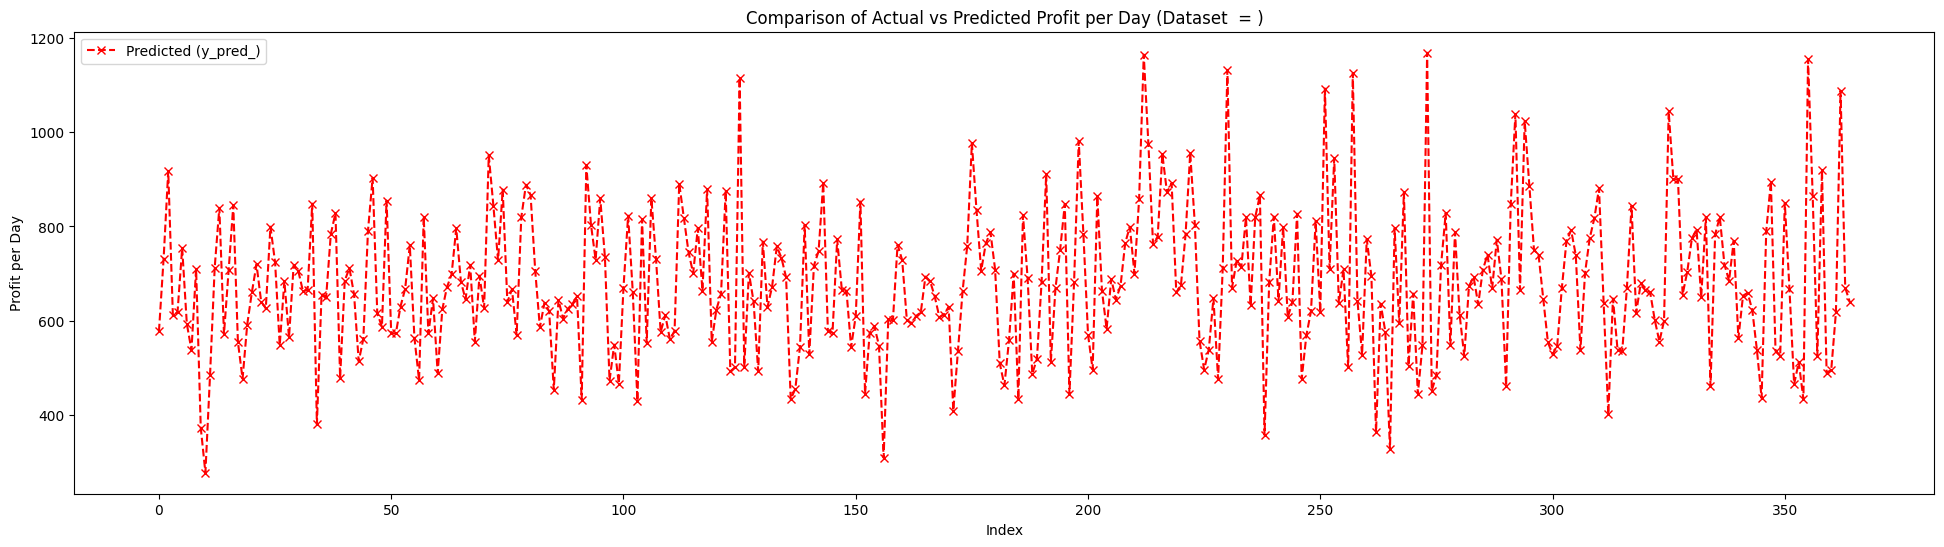

In [103]:
import matplotlib.pyplot as plt

# y_pred = mainModel.predict(X_test)
plt.figure(figsize=(24, 6))
# plt.plot(y_test.index, y_test, label=f'Actual (y_test_)', color='blue', linestyle='-', marker='o')
plt.plot(df.index, df['Profit_Per_Day'], label=f'Predicted (y_pred_)', color='red', linestyle='--', marker='x')
plt.title(f'Comparison of Actual vs Predicted Profit per Day (Dataset  = )')
plt.xlabel('Index')
plt.ylabel('Profit per Day')
plt.legend()
plt.show()


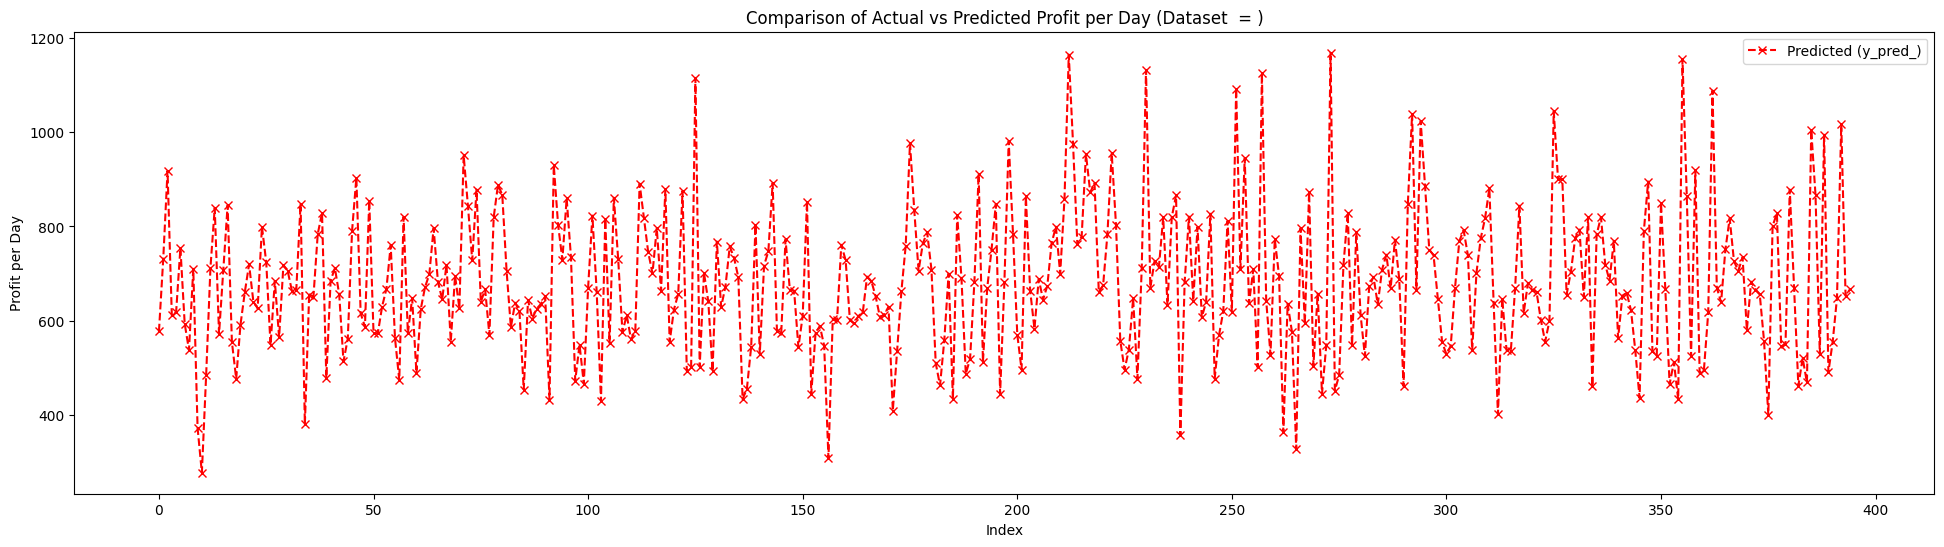

In [101]:
import matplotlib.pyplot as plt

# y_pred = mainModel.predict(X_test)
plt.figure(figsize=(24, 6))
# plt.plot(y_test.index, y_test, label=f'Actual (y_test_)', color='blue', linestyle='-', marker='o')
plt.plot(dftestt.index, dftestt['Profit_Per_Day'], label=f'Predicted (y_pred_)', color='red', linestyle='--', marker='x')
plt.title(f'Comparison of Actual vs Predicted Profit per Day (Dataset  = )')
plt.xlabel('Index')
plt.ylabel('Profit per Day')
plt.legend()
plt.show()


## Training sendiri